In [1]:
import pandas as pd
import numpy as np
import difflib
import copy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
import pyodbc
import time
import sys
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
plt.style.use('ggplot')

# src imports
sys.path.append('../../')
#import src.data.sql_query_fns as sql_fn

In [3]:
cnxn = pyodbc.connect("Driver={ODBC Driver 17 for SQL Server};"
                      "Server=USNAPWPDB11;"
                      "Database=TRASAR3;"
                       "Trusted_Connection=yes;")

In [4]:
CT_prediction = pd.read_csv('C:/Users/wanru/OneDrive - Ecolab/Desktop/tlm_analysis/data/processed/08-13-20-CT-abs-total-error.csv')

GT_prediction = pd.read_csv('C:/Users/wanru/OneDrive - Ecolab/Desktop/tlm_analysis/data/processed/08-11-20-GT-abs-total-error.csv')

Arima = pd.read_csv('C:/Users/wanru/OneDrive - Ecolab/Desktop/tlm_analysis/data/processed/08-04-20-arima_error_results.csv')
Arima_GT = pd.read_csv('C:/Users/wanru/OneDrive - Ecolab/Desktop/tlm_analysis/data/processed/arima_error_results_gateway.csv')

In [4]:
GT_prediction

,TANK_ID,abs_total_error
0,1282,279.794364
1,4730,60.305067
2,4731,23.734630
3,4732,50.148931
4,4733,18.709830
...,...,...
123,375013,99.248745
124,375414,65.920343
125,386783,2.186375
126,387170,96.668556


In [5]:
CT = pd.read_sql(f'SELECT TankID, TankVolume FROM TLA.Tanks WHERE TankID in {tuple(CT_prediction.TANK_ID.to_list())}', cnxn)
CT
GT = pd.read_sql(f'SELECT TankID, TankVolume FROM TLA.Tanks WHERE TankID in {tuple(GT_prediction.TANK_ID.to_list())}', cnxn)
GT

,TankID,TankVolume
0,224741,400.0
1,387170,105.0
2,386783,120.0
3,375414,105.0
4,375013,120.0
...,...,...
119,11981,280.0
120,8694,2050.0
121,8693,850.0
122,5286,105.0


In [6]:
CT_tank_volumes = pd.DataFrame(CT['TankVolume'].values, index=CT['TankID']).to_dict()[0]
GT_tank_volumes = pd.DataFrame(GT['TankVolume'].values, index=GT['TankID']).to_dict()[0]

In [7]:
CT_prediction['Volume'] = CT_prediction['TANK_ID'].map(CT_tank_volumes)
GT_prediction['Volume'] = GT_prediction['TANK_ID'].map(GT_tank_volumes)

In [8]:
GT_prediction

,TANK_ID,abs_total_error,Volume
0,1282,279.794364,385.0
1,4730,60.305067,110.0
2,4731,23.734630,120.0
3,4732,50.148931,120.0
4,4733,18.709830,120.0
...,...,...,...
123,375013,99.248745,120.0
124,375414,65.920343,105.0
125,386783,2.186375,120.0
126,387170,96.668556,105.0


In [8]:
CT_prediction['Norm_ABS_Cons_Err'] = CT_prediction.abs_total_error/CT_prediction.Volume
GT_prediction['Norm_ABS_Cons_Err'] = GT_prediction.abs_total_error/GT_prediction.Volume

In [10]:
GT_prediction

,TANK_ID,abs_total_error,Volume,Norm_ABS_Cons_Err
0,1282,279.794364,385.0,0.726739
1,4730,60.305067,110.0,0.548228
2,4731,23.734630,120.0,0.197789
3,4732,50.148931,120.0,0.417908
4,4733,18.709830,120.0,0.155915
...,...,...,...,...
123,375013,99.248745,120.0,0.827073
124,375414,65.920343,105.0,0.627813
125,386783,2.186375,120.0,0.018220
126,387170,96.668556,105.0,0.920653


In [11]:
Arima_GT

,TANK_ID,abs_total_error,Norm_ABS_Cons_Err,Volume
0,1282,387.225613,1.005781,385.0
1,4730,61.977025,0.563428,110.0
2,4731,33.007555,0.275063,120.0
3,4732,53.438963,0.445325,120.0
4,4733,20.980714,0.174839,120.0
...,...,...,...,...
123,375013,118.380343,0.986503,120.0
124,375414,65.725712,0.625959,105.0
125,386783,1.169333,0.009744,120.0
126,387170,95.546939,0.909971,105.0


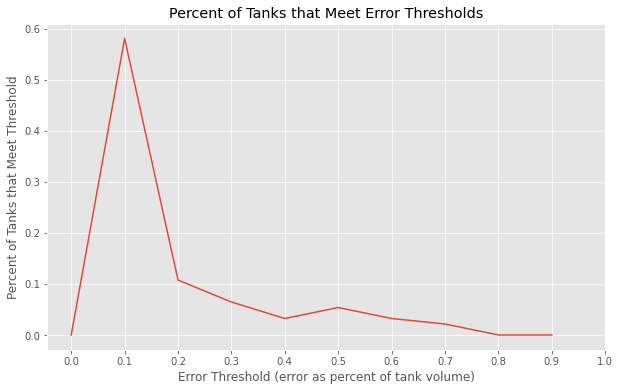

In [9]:
errors = []
for i in range(10):
    errors.append(len(CT_prediction[(CT_prediction['Norm_ABS_Cons_Err'] >=0.1*max(0, (i-1))) & (CT_prediction['Norm_ABS_Cons_Err'] <=0.1*i)])/len(CT_prediction))

plt.figure(figsize=(10,6))
plt.title('Percent of Tanks that Meet Error Thresholds')
plt.plot(np.linspace(0,0.9,10), errors)
plt.xlabel('Error Threshold (error as percent of tank volume)')
plt.ylabel('Percent of Tanks that Meet Threshold')
plt.xticks(np.linspace(0,1,11))
plt.show()

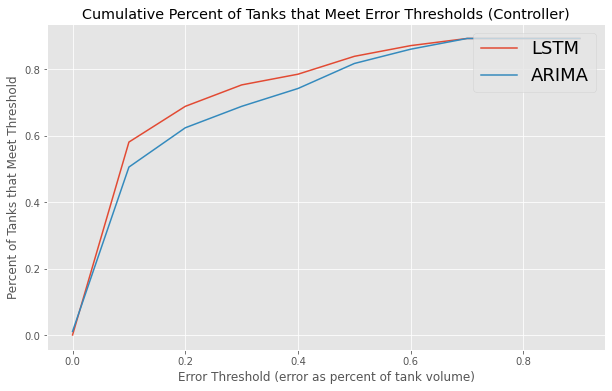

In [10]:
errors = []
errors_arima = []
for i in range(10):
    errors.append(len(CT_prediction[CT_prediction['Norm_ABS_Cons_Err'] <=0.1*i])/len(CT_prediction))
    errors_arima.append(len(Arima[Arima['Norm_ABS_Cons_Err'] <=0.1*i])/len(Arima))

plt.figure(figsize=(10,6))
plt.title('Cumulative Percent of Tanks that Meet Error Thresholds (Controller)')
plt.plot(np.linspace(0, 0.9,10), errors, label = 'LSTM')
plt.plot(np.linspace(0, 0.9,10), errors_arima, label = 'ARIMA')

plt.legend( loc='upper right', prop={'size': 18})

plt.xlabel('Error Threshold (error as percent of tank volume)')
plt.ylabel('Percent of Tanks that Meet Threshold')
plt.show()

**Gateway**

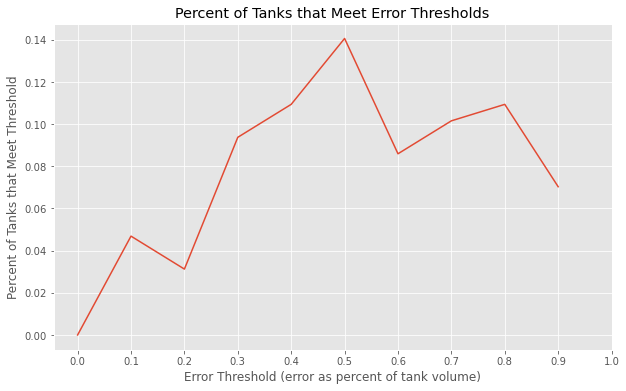

In [14]:
errors = []
errors_arima = []
for i in range(10):
    errors.append(len(GT_prediction[(GT_prediction['Norm_ABS_Cons_Err'] >=0.1*max(0, (i-1))) & (GT_prediction['Norm_ABS_Cons_Err'] <=0.1*i)])/len(GT_prediction))
    errors_arima.append(len(Arima_GT[(Arima_GT['Norm_ABS_Cons_Err'] >=0.1*max(0, (i-1))) & (Arima_GT['Norm_ABS_Cons_Err'] <=0.1*i)])/len(Arima_GT))

plt.figure(figsize=(10,6))
plt.title('Percent of Tanks that Meet Error Thresholds')
plt.plot(np.linspace(0,0.9,10), errors)
plt.xlabel('Error Threshold (error as percent of tank volume)')
plt.ylabel('Percent of Tanks that Meet Threshold')
plt.xticks(np.linspace(0,1,11))
plt.show()

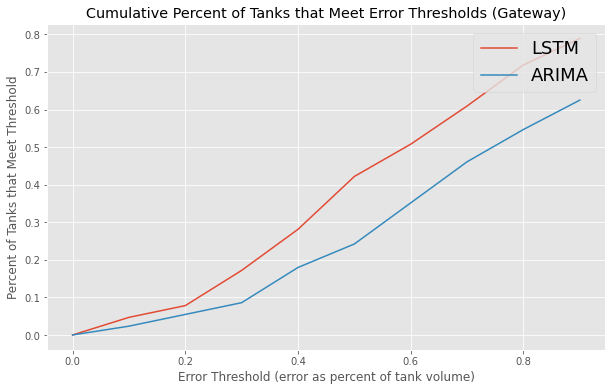

In [15]:
errors = []
errors_arima = []
for i in range(10):
    errors.append(len(GT_prediction[GT_prediction['Norm_ABS_Cons_Err'] <=0.1*i])/len(GT_prediction))
    errors_arima.append(len(Arima_GT[Arima_GT['Norm_ABS_Cons_Err'] <=0.1*i])/len(Arima_GT))

plt.figure(figsize=(10,6))
plt.title('Cumulative Percent of Tanks that Meet Error Thresholds (Gateway)')

plt.plot(np.linspace(0, 0.9,10), errors, label = 'LSTM')
plt.plot(np.linspace(0, 0.9,10), errors_arima, label = 'ARIMA')
plt.legend( loc='upper right', prop={'size': 18})

plt.xlabel('Error Threshold (error as percent of tank volume)')
plt.ylabel('Percent of Tanks that Meet Threshold')
plt.show()

**Arima**

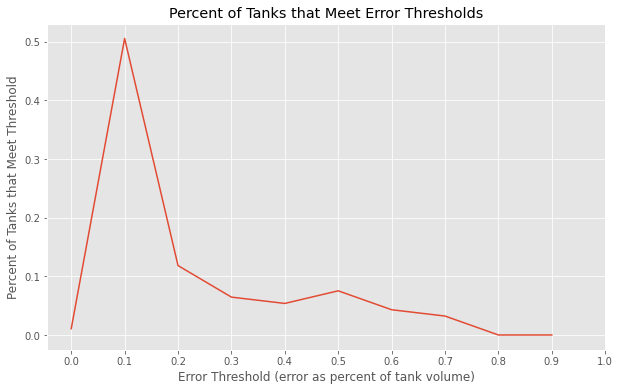

In [16]:
errors = []
for i in range(10):
    errors.append(len(Arima[(Arima['Norm_ABS_Cons_Err'] >=0.1*max(0, (i-1))) & (Arima['Norm_ABS_Cons_Err'] <=0.1*i)])/len(Arima))

plt.figure(figsize=(10,6))
plt.title('Percent of Tanks that Meet Error Thresholds')
plt.plot(np.linspace(0,0.9,10), errors)
plt.xlabel('Error Threshold (error as percent of tank volume)')
plt.ylabel('Percent of Tanks that Meet Threshold')
plt.xticks(np.linspace(0,1,11))
plt.show()

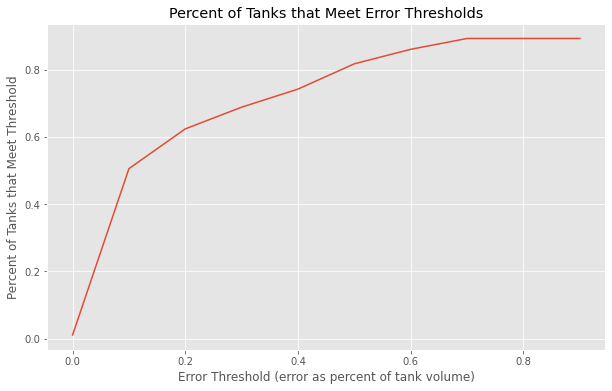

In [17]:
errors = []
for i in range(10):
    errors.append(len(Arima[Arima['Norm_ABS_Cons_Err'] <=0.1*i])/len(Arima))
    
plt.figure(figsize=(10,6))
plt.title('Percent of Tanks that Meet Error Thresholds')
plt.plot(np.linspace(0, 0.9,10), errors)
plt.xlabel('Error Threshold (error as percent of tank volume)')
plt.ylabel('Percent of Tanks that Meet Threshold')
plt.show()